Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

With it's diverse culture, comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great French Cuisine.

Data

For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.

French resturants in each neighborhood of new york city.
Data source : Fousquare API
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only French resturants.
GeoSpace data
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

Approach
Collect the new york city data from https://cocl.us/new_york_dataset
Using FourSquare API we will find all venues for each neighborhood.
Filter out all venues that are French Resturants.
Find rating , tips and like count for each French Resturants using FourSquare API.
Using rating for each resturant , we will sort that data.
Visualize the Ranking of neighborhoods using folium library(python)
Questions that can be asked using the above mentioned datasets
What is best location in New York City for French Cuisine ?
Which areas have potential French Resturant Market ?
Which all areas lack French Resturants ?
Which is the best place to stay if I prefer French Cuisine ?
Analysis
We will import the required libraries for python.

pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import folium # map rendering library
print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [9]:
address = 'New York'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

radius=1000
LIMIT=100
CLIENT_ID = 'UOF5JBN3J2LERBUBTHMNIEGNLPG0OMT4HWLIMPGKGSCWQCCW'
CLIENT_SECRET = '3WPNTATDZHW13NK1WEHSN1MG10QDB1ABR3VEWELRVJJPHCO5'
VERSION = '20180604' # Foursquare API version
    
    
    #url to fetch data from foursquare api
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude)
    
    # get all the data
results = requests.get(url).json()
results

    

40.7127281 -74.0060152


{'meta': {'code': 400,
  'errorType': 'invalid_auth',
  'errorDetail': 'Missing access credentials. See https://developer.foursquare.com/docs/api/configuration/authentication for details.',
  'requestId': '5d4eb5b45bc9e3002426726e'},
 'response': {}}

In [27]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'UOF5JBN3J2LERBUBTHMNIEGNLPG0OMT4HWLIMPGKGSCWQCCW'
    CLIENT_SECRET = '3WPNTATDZHW13NK1WEHSN1MG10QDB1ABR3VEWELRVJJPHCO5' # your Foursquare Secret
    VERSION = '20180604' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
       # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [28]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'UOF5JBN3J2LERBUBTHMNIEGNLPG0OMT4HWLIMPGKGSCWQCCW' # your Foursquare ID
    CLIENT_SECRET = '3WPNTATDZHW13NK1WEHSN1MG10QDB1ABR3VEWELRVJJPHCO5' # your Foursquare Secret
    VERSION = '20180604' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [29]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [30]:
# get new york data
new_york_data=get_new_york_data()

In [31]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [32]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

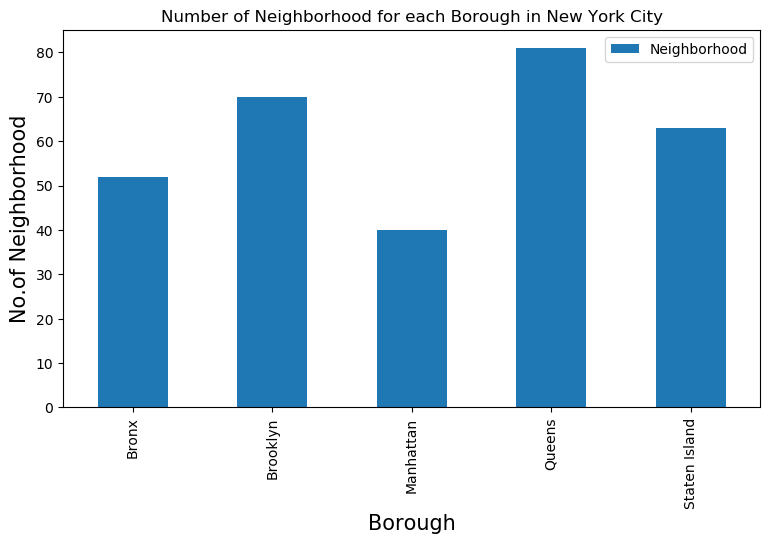

In [33]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect French resturants for each Neighborhood

In [34]:
# prepare neighborhood list that contains french restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
french_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_restaurants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(new_york_data),')','French Restaurants in '+Neighborhood+', '+Borough+':'+str(len(french_restaurants)))
    for restaurant_detail in french_restaurants.values.tolist():
        id, name , category=restaurant_detail
        french_rest_ny = french_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) French Restaurants in Wakefield, Bronx:0
( 2 / 306 ) French Restaurants in Co-op City, Bronx:0
( 3 / 306 ) French Restaurants in Eastchester, Bronx:0
( 4 / 306 ) French Restaurants in Fieldston, Bronx:0
( 5 / 306 ) French Restaurants in Riverdale, Bronx:0
( 6 / 306 ) French Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) French Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) French Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) French Restaurants in Norwood, Bronx:0
( 10 / 306 ) French Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) French Restaurants in Baychester, Bronx:0
( 12 / 306 ) French Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) French Restaurants in City Island, Bronx:1
( 14 / 306 ) French Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) French Restaurants in University Heights, Bronx:0
( 16 / 306 ) French Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) French Restaurants in Fordham, Bronx:0
( 18 / 306 ) French Restaurants in East Tremont, Bronx:

Now that we have got all the French resturants in new york city , we will analyze it

In [35]:
french_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock


In [36]:
french_rest_ny.shape

(95, 4)

We got 95 French Resturants across New York City

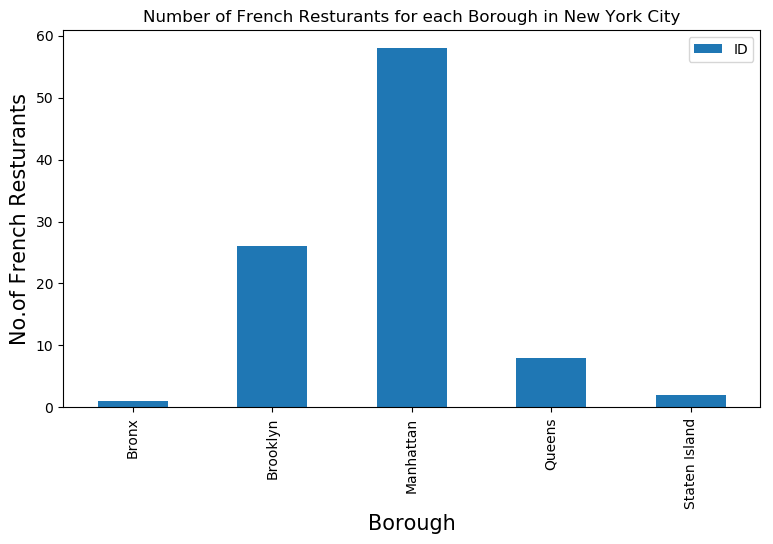

In [37]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=15)
#giving a bar plot
french_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Manhattan has the largest number of french resturants

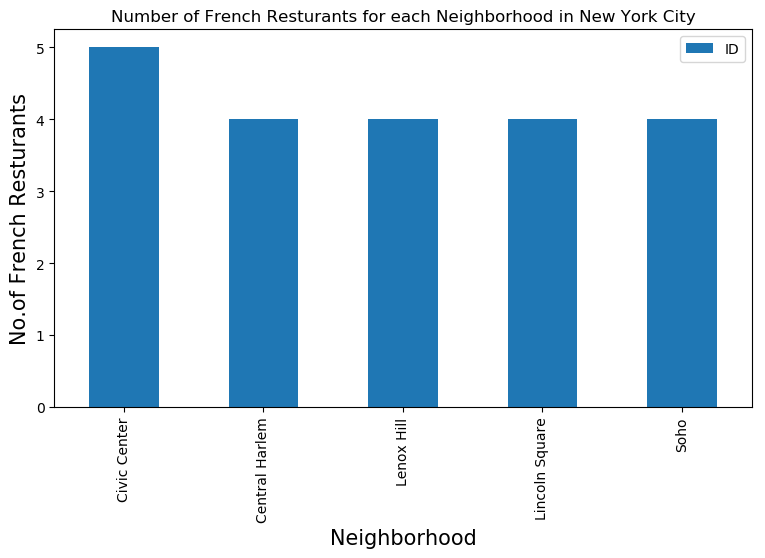

In [38]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of French Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of French Resturants', fontsize=15)
#giving a bar plot
french_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [39]:
french_rest_ny[french_rest_ny['Neighborhood']=='Civic Center']

,Borough,Neighborhood,ID,Name
77,Manhattan,Civic Center,3fd66200f964a52083e61ee3,The Odeon
78,Manhattan,Civic Center,566c9c87498ef09a2940e605,Maman
79,Manhattan,Civic Center,58191674ded8f8626ed70af0,Augustine
80,Manhattan,Civic Center,5abc33ccad17896edaca3d61,Frenchette
81,Manhattan,Civic Center,57583641498e90001a32e13e,Le Coucou


So Civic Center in Manhattan has the highest number of French Resturants with a total count of 5.

Now we will get the ranking of each resturant for further analysis.

In [41]:
# prepare neighborhood list that contains french resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
french_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in french_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(french_rest_ny),')','processed')
    french_rest_stats_ny = french_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4d7aa83ee540f04d66ba16dc  Bistro SK     14     7.6     7
( 1 / 95 ) processed
                         ID     Name  Likes  Rating  Tips
0  5bf358689fca56002c251a87  Citroën     16     8.9     2
( 2 / 95 ) processed
                         ID           Name  Likes  Rating  Tips
0  58fd34584382ab70ad90083e  Chez Ma Tante    191     9.0    50
( 3 / 95 ) processed
                         ID      Name  Likes  Rating  Tips
0  4bcf1883c564ef3ba33beff0  Le Gamin    156     8.0    72
( 4 / 95 ) processed
                         ID        Name  Likes  Rating  Tips
0  4e7d174cb6340a4da75a2cca  Le Paddock    129     8.6    54
( 5 / 95 ) processed
                         ID        Name  Likes  Rating  Tips
0  5a7f2773d1a40265ea809163  La Cafette     33     8.7     7
( 6 / 95 ) processed
                         ID         Name  Likes  Rating  Tips
0  465c180df964a5202a471fe3  Le Barricou    828     8.9   281
( 7 / 95 ) processed
   

In [42]:
french_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,14,7.6,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,16,8.9,2
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,191,9.0,50
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,156,8.0,72
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,129,8.6,54


In [43]:
french_rest_stats_ny.shape

(95, 7)

In [44]:
french_rest_ny.shape

(95, 4)

We got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [45]:
french_rest_stats_ny.to_csv('french_rest_stats_ny.csv', index=False)

Verify the data from saved csv file

In [46]:
french_rest_stats_ny_csv=pd.read_csv('french_rest_stats_ny.csv')

In [47]:
french_rest_stats_ny_csv.shape

(95, 7)

In [49]:
french_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,14,7.6,7
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,16,8.9,2
2,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,191,9.0,50
3,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,156,8.0,72
4,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,129,8.6,54


In [50]:
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 7 columns):
Borough         95 non-null object
Neighborhood    95 non-null object
ID              95 non-null object
Name            95 non-null object
Likes           95 non-null object
Rating          95 non-null float64
Tips            95 non-null object
dtypes: float64(1), object(6)
memory usage: 5.3+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [51]:
french_rest_stats_ny['Likes']=french_rest_stats_ny['Likes'].astype('float64')
french_rest_stats_ny['Tips']=french_rest_stats_ny['Tips'].astype('float64')
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 7 columns):
Borough         95 non-null object
Neighborhood    95 non-null object
ID              95 non-null object
Name            95 non-null object
Likes           95 non-null float64
Rating          95 non-null float64
Tips            95 non-null float64
dtypes: float64(3), object(4)
memory usage: 5.3+ KB


In [52]:
# Resturant with maximum Likes
french_rest_stats_ny.iloc[french_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              3fd66200f964a52070e91ee3
Name                           Balthazar
Likes                               2998
Rating                                 9
Tips                                1044
Name: 49, dtype: object

In [53]:
# Resturant with maximum Tips
french_rest_stats_ny.iloc[french_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              3fd66200f964a52070e91ee3
Name                           Balthazar
Likes                               2998
Rating                                 9
Tips                                1044
Name: 49, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [54]:
ny_neighborhood_stats=french_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [55]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
48,West Village,9.30
16,East Harlem,9.10
9,Chinatown,9.10
27,Little Italy,9.05
38,Soho,9.00
8,Chelsea,9.00
22,Greenwich Village,9.00
15,Downtown,9.00
33,Noho,8.90
39,South Side,8.90


Above are the top neighborhoods with top average rating of Indian resturants

In [56]:
ny_borough_stats=french_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [57]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.653448
1,Brooklyn,8.569231
3,Queens,7.862500
0,Bronx,7.600000
4,Staten Island,7.000000


Similarly these are the average rating of french Resturants for each Borough

Lets visualize it

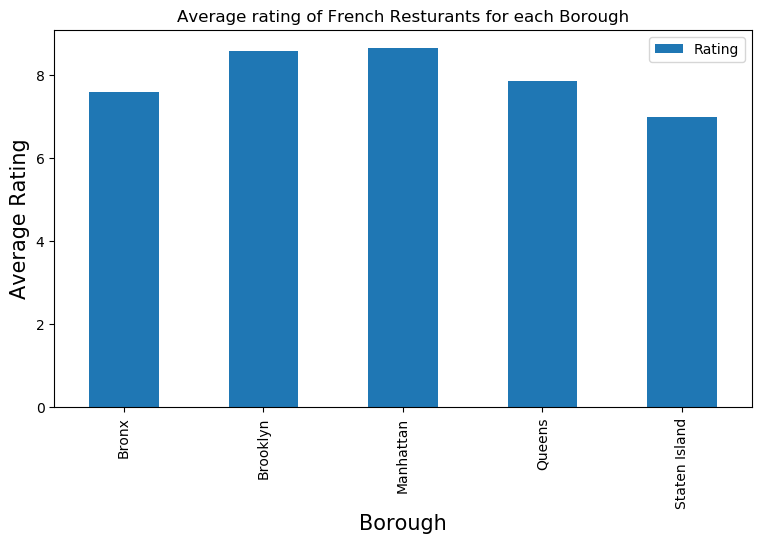

In [58]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of French Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
french_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [59]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
8,Chelsea,9.00
9,Chinatown,9.10
15,Downtown,9.00
16,East Harlem,9.10
22,Greenwich Village,9.00
27,Little Italy,9.05
38,Soho,9.00
48,West Village,9.30


We will join this dataset to original new york data to get lonitude and latitude

In [60]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.00
1,Staten Island,Chelsea,40.594726,-74.189560,9.00
2,Manhattan,Chinatown,40.715618,-73.994279,9.10
3,Brooklyn,Downtown,40.690844,-73.983463,9.00
4,Manhattan,East Harlem,40.792249,-73.944182,9.10
5,Manhattan,Greenwich Village,40.726933,-73.999914,9.00
6,Manhattan,Little Italy,40.719324,-73.997305,9.05
7,Manhattan,Soho,40.722184,-74.000657,9.00
8,Manhattan,West Village,40.734434,-74.006180,9.30


Now we will show this data on a map

In [63]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)



In [64]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()



In [65]:
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [66]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [67]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

West Village in manhattan seems to be the best place for French Restaurant